In [1]:
# library imports
from importlib import reload
from copy import deepcopy
from Classes import ClusterObj, BlockObj, ScanDataObj
from Functions import CommonFunctions, ClassesFunctions
import pickle
import pandas as pd
reload(CommonFunctions)
reload(ClassesFunctions)
reload(ClusterObj)
reload(BlockObj)
reload(ScanDataObj)

print('Done!')

Done!


In [73]:
import os
import pandas as pd
from openpyxl import load_workbook

def combine_excel_files(input_folder):
    sheet_data = {}

    # Collect all data into a dictionary with sheet names as keys
    for file in os.listdir(input_folder):
        if file.endswith("summary.xlsx"):
            file_path = os.path.join(input_folder, file)

            # Extract the custom sheet name based on the filename
            parts = file.split("_")
            if len(parts) >= 4:
                sheet_name = f"{parts[0]}_{parts[3]}"  # Combine the first and fourth parts
                sheet_name = sheet_name[:31]  # Limit to 31 characters (Excel's limit)
            else:
                sheet_name = file[:31]  # Fallback to file name if not enough parts

            try:
                # Read the Excel file
                df = pd.read_excel(file_path, engine='openpyxl')

                # Remove '_0' or '_1' from dAb column names
                df.columns = [
                    col[:-2] if col.startswith("dAb") and col[-2:] in ["_0"] else col
                    for col in df.columns
                ]

                sheet_data[sheet_name] = df
            except Exception as e:
                # Log the error and skip the file
                print(f"Failed to process {file}: {e}")

    # Sort the dictionary by sheet name
    sorted_sheets = dict(sorted(sheet_data.items()))

    # Output file path (same folder as inputs)
    output_file = os.path.join(input_folder, "combined_summary_results.xlsx")

    # Write sorted sheets to the output Excel file
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        for sheet_name, df in sorted_sheets.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)

    # Adjust column widths for dAb columns
    workbook = load_workbook(output_file)
    for sheet_name in workbook.sheetnames:
        worksheet = workbook[sheet_name]
        for col in worksheet.columns:
            col_letter = col[0].column_letter
            if col[0].value and str(col[0].value).startswith("dAb"):
                worksheet.column_dimensions[col_letter].width = 15
            else:
                worksheet.column_dimensions[col_letter].width = 10
    workbook.save(output_file)


path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/P24-1204"

combine_excel_files(path)


In [83]:
import pandas as pd
import re
from openpyxl import load_workbook


def sanitize_sheet_name(sheet_name):
    # Replace invalid characters with an underscore
    return re.sub(r'[\\/:*?\"<>|]', '_', sheet_name)

def group_unique_combinations_and_save(input_file):
    # Load the combined Excel file
    combined_df = pd.read_excel(input_file, sheet_name=None, engine='openpyxl')
    workbook = load_workbook(input_file)

    # Create a dictionary to store the grouped columns by unique combinations of dAb and cAb
    grouped_columns = {}

    # Iterate through all sheets in the combined file
    for sheet_name, df in combined_df.items():
        # Skip hidden sheets
        if workbook[sheet_name].sheet_state == 'hidden':
            continue

        for col in df.columns:
            # Identify if the column starts with 'dAb' followed by '_cAb'
            if col.startswith('dAb') and ('_cAb' in col or 'anti_' in col):
                # Extract the combination of 'dAbX_cAbY' (e.g., 'dAb10_cAb11')
                base_name = '_'.join(col.split('_')[:2])

                # Initialize the base name dictionary if it doesn't exist
                if base_name not in grouped_columns:
                    grouped_columns[base_name] = {'SD4': [], 'OF': []}

                # Append the column to the appropriate sheet type (SD4 or OF)
                if sheet_name.endswith('_SD4'):
                    grouped_columns[base_name]['SD4'].append((sheet_name, col))
                elif sheet_name.endswith('_OF'):
                    grouped_columns[base_name]['OF'].append((sheet_name, col))

    # Create a new Excel file with the grouped columns
    output_file = input_file.replace('.xlsx', '_grouped_unique_combinations.xlsx')

    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # For each unique combination of dAb and cAb
        for group_name, sheet_types in grouped_columns.items():
            # For each sheet type (SD4 and OF)
            for sheet_type, column_info in sheet_types.items():
                # Prepare a list to store columns
                columns_list = []
                if len(column_info) < 1 :
                    continue
                # Add ag_conc column to the list as the first column
                ag_conc_col = combined_df[column_info[0][0]]['Ag_Conc.']  # Getting ag_conc from the first sheet
                columns_list.append(ag_conc_col.rename('Ag_Conc.'))

                # Add the columns corresponding to this group
                for idx, (sheet_name, col_name) in enumerate(column_info):
                    # Add columns with new names ('sheetX', 'sheetX_01', etc.)
                    new_column_name = f"{sheet_name}_{idx}"
                    columns_list.append(combined_df[sheet_name][col_name].rename(new_column_name))

                # Concatenate all columns in one DataFrame
                new_df = pd.concat(columns_list, axis=1)
                sanitized_sheet_name = sanitize_sheet_name(f"{group_name}_{sheet_type}")

                # Write the grouped DataFrame to a new sheet in the Excel file
                # new_sheet_name = f"{group_name}_{sheet_type}"
                new_df.to_excel(writer, sheet_name=sanitized_sheet_name, index=False)
     # Adjust column widths for dAb columns
    workbook = load_workbook(output_file)
    for sheet_name in workbook.sheetnames:
        worksheet = workbook[sheet_name]
        for col in worksheet.columns:
            col_letter = col[0].column_letter
            if col[0].value and str(col[0].value).startswith("Day"):
                worksheet.column_dimensions[col_letter].width = 15
            else:
                worksheet.column_dimensions[col_letter].width = 10
    workbook.save(output_file)
    print(f"Grouped file saved as {output_file}")

# Example usage
group_unique_combinations_and_save(f"{path}/combined_summary_results.xlsx")


Grouped file saved as /Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/P24-1204/combined_summary_results_grouped_unique_combinations.xlsx


In [2]:
# path setup
path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/P25-0114/"
input_file_name = 'Day3_S2_N3_SD4_5um'

image, scaled_image = CommonFunctions.load_image(file_name=input_file_name, path=path, debug=False, plot_images=False, rotation=0)
print(f'Loaded Image "{input_file_name}" {image.shape}')

# CommonFunctions.show(scaled_image)


Loaded Image "Day3_S2_N3_SD4_5um" (14400, 4400)


In [3]:
# load the saved work, or start over:
scan_data = ClassesFunctions.read_scan_data_from_pickle(
    file_name=input_file_name,
    path=path,
    start_over=False, # if True -> ignores the pickle, and returns None for initiating with the following functions
    plot_results=False,
    debug=False
)

reset = False
if scan_data is None or reset:
    print('Need to start over and make the dataset')
    start_over = True
else:
    print(f'Successfully loaded scan_data for "{input_file_name}"')
    start_over = False



No file with name Day3_S2_N3_SD4_5um -> calling this function again to start over!
start_over is True, so I'm exiting by returning None
Need to start over and make the dataset


In [4]:
## Setting the parameters:
input_param_dict = {
    'scan_size': 5,       # scanned at 5 or 10 µm
    'assay': 'SD4',       # put either "SD4" (screening D4) or "OF" (open format)
    'cAb_names': ['anti_cy5_0.7','anti_cy5_0.3','cAb49_DI','cAb49_Tre','cAb10_DI','cAb10_Tre','cAb35_DI','cAb35_Tre','cAb45_DI','cAb45_Tre','mix_cAbs','cAb28','mix_cAbs'] # can be None or [] too
}

In [5]:
# reset = True/False to overwrite start_over
if start_over or not hasattr(scan_data, 'sorted_circles') or not hasattr(scan_data, 'circle_finding_params_hough'):
    reset = True
ScanDataObj.init_or_reset_params(file_name=input_file_name, reset=reset, input_param_dict=input_param_dict, debug=False)


Successfully set the params for Day3_S2_N3_SD4_5um -> {} :)


In [6]:
# todo: add a function for parameter tuning...
start_over

True

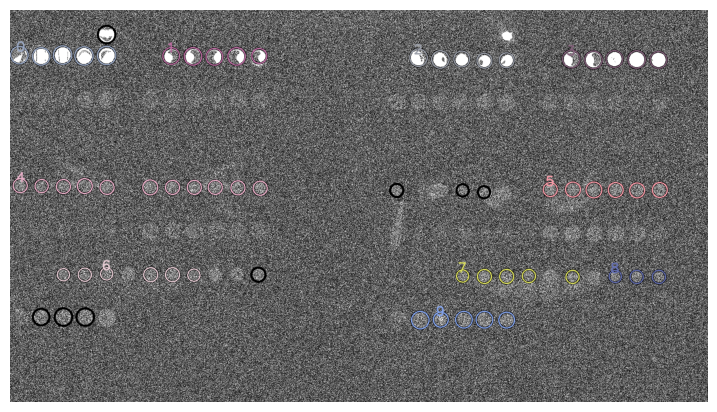

In [7]:
# test current parameters. can optimize them too if the results are not looking good.
if start_over:
    test_image = deepcopy(image)[100:1000,1400:3000] #(y,x) -> change if u want!
    # checkme takes too long
    # CommonFunctions.optimize_the_params(file_name=input_file_name, input_image=test_image, how_many_times=1, plot_images=False, debug=False)
    CommonFunctions.test_current_parameters(input_image=test_image, file_name=input_file_name, fig_size=[9,9], debug=False)

In [ ]:
# start_over=True
if start_over or not hasattr(scan_data, 'sorted_circles') or not hasattr(scan_data, 'circle_finding_params_hough'):
    CommonFunctions.do_initial_circle_finding(file_name=input_file_name, debug=False, plot_images=False)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
else:
    sorted_circles = scan_data.sorted_circles
    predicted_clusters_ids = scan_data.predicted_clusters_ids

In [ ]:
# start_over = True
if start_over:
    ClassesFunctions.init_blocks_dict(
        file_name=input_file_name, debug=False, plot_blocks=start_over,
        # debug_block_ids=['r0c0','r0c1','r0c2','r0c3'],
        init_offset=[-50,-20],
        block_size_adjustment=[50,80],
        block_distance_adjustment=[2,2],
    )
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
else:
    ClassesFunctions.plot_blocks_on_image(file_name=input_file_name, debug=False)

In [ ]:
scan_data = ScanDataObj.get_scan_data(input_file_name)

In [ ]:
# start_over = True
if start_over:
    ClassesFunctions.init_clusters_dict(scan_data.sorted_circles, scan_data.predicted_clusters_ids, input_file_name,
                                        optimize_spots_coords=True, debug=False, debug_clusters_ids=[])
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
# connect clusters and blocks (and final initiation stuff)
if start_over:
    ClassesFunctions.connect_clusters_to_blocks(file_name=input_file_name,debug=False,debug_clusters=[],debug_blocks=[],plot_images=False,)


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
## Making the first template of cluster patterns
start_over=True

scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
test_ind = f'r0c3'
test_block: BlockObj.Block = scan_data.get_block(test_ind)

if start_over:
    test_block.reset_block_start_end_coords(debug=False)
    manual_spot_edit_dict = {
        0:['add 1 to r','move spot-1 50 u, 50 l'],
        2:['add 2 clusters above d=100','add 1 cluster below d=100'],
        4:['add 1 clusters above d=200'],
        3:['add 4 to r','move spot-1 5 u, 3 l','change_r spot-1 r+1'],
        188:['change_r all r-3','add 3 clusters above d=100'],
        189:['change_r all r-2','move all 5 d, 2 l','move spot0 2 u, 2 r','move spot-1 4 l , 11 d'],
    }
    test_block.edit_block(debug=0, plot_before_after=False, overwrite=True,with_restore=True,
                          manual_spot_edit_dict=manual_spot_edit_dict)
    test_mask = test_block.create_block_mask(debug=False, plot_images=False)
    test_block.plot_block(fig_size=[6, 6], debug=False, with_border=True, crop_to_mask=True)
    N = len(test_block.clusters_ids_list)
    print(f'There are {N} clusters in total.')
    # print(test_block.full_report(1))


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
# generating the list to edit each row at the same time
generate_list = lambda n: [f'r{n}c{i}' for i in range(scan_data.block_ncol)]
rows_names_list = []
for r in range(scan_data.block_nrow):
    rows_names_list.append(generate_list(r))

In [ ]:
# row 0
r = 0
plot_results = False if start_over else True
current_list = rows_names_list[r]
fig_size = [10,10] if scan_data.assay == 'SD4' else [15,15]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        restore_block_coords=current_list,
        move_whole_block_match={'r0c0':[64,62],'r0c1':[66,63],'r0c2':[64,57]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c2'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            192:['change_r all r-4','move spot-1 4 d','move spot-2 2 d, 2 r','move spot-2 4 d','move spot2 1 r'],
            204:['change_r all r-5'],216:['change_r all r-5'],
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

# print(scan_data.get_block('r0c1').full_report(1))

In [ ]:
## row 1
r = 1
current_list = rows_names_list[r]

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        move_whole_block_match={'r1c0':[0,0],'r1c2':[0,0],'r1c3':[60,50]},
        manual_spot_edit_dict={
            5:['move spot-2 10 u','change_r spot-2 r+2'],
            9:['change_r spot-2 r+2'],
            232:['move spot-1 11 u, 5 r'],
            239:['move spot-1 11 u, 5 r'],
            246:['move spot-1 11 u, 5 r'],
            253:['move spot-1 10 u, 6 r'],
            20:['move spot-1 7 d, 7 r'],
            19:['move spot-1 7 d, 7 r'],
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

In [ ]:
# row 2
r = 2
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        move_whole_block_match={'r2c0':[0,0],'r2c1':[0,0],'r2c2':[0,0],'r2c3':[0,0]},
        manual_spot_edit_dict={
            25:['change_r spot-1 r+2'],
            35:['move spot-1 2 u, 2 l'],
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

In [ ]:
# row 3
r = 3
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        # move_whole_block_match={'r3c0':[0,-100],'r3c1':[0,-100],'r3c3':[0,-100]},
        manual_spot_edit_dict={
            20:['move spot-1 7 d, 7 r'],
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 4
r = 4
start_over = 1
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        # move_whole_block_match={'r4c0':[-10,-10],'r4c1':[0,0],'r4c2':[0,0],'r4c3':[0,0]},
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 5
r = 5
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        # move_whole_block_match={'r5c0':[-20,-20],'r5c1':[0,0], 'r5c3':[0,0]},
        manual_spot_edit_dict={
            78:['move spot-1 3 l'],72:['change_r spot-1 r+2'],76:['change_r spot-1 r+2']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 6
r = 6
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        # move_whole_block_match={'r6c0':[-50,-10],'r6c3':[0,0]},
        manual_spot_edit_dict={
            # 195:['move all 1 d']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 7
r = 7
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        move_whole_block_match={'r7c0':[0,-10], 'r7c1':[0,0],'r7c2':[0,0],'r7c3':[0,0]},
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 8
if scan_data.block_nrow > 8:
    r = 8
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
            debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
            preprocess_params=scan_data.preprocess_params, plot_before_after=0,
            restore_block_coords=current_list,
            move_whole_block_match={'r8c0':[0,-10], 'r8c1':[0,0],'r8c2':[0,0],},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 9
if scan_data.block_nrow > 8:
    r = 9
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            move_whole_block_match={'r9c0':[0,-50],'r9c1':[0,-20],'r9c2':[40,-20],'r9c3':[20,0]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 10
if scan_data.block_nrow > 8:
    r = 10
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r10c0':[-60,-30],'r10c1':[0,-20],'r10c2':[-20,-10]},
            manual_spot_edit_dict={
                # 139:['change_r all r+1','move spot0 3 l, 6 d']
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)



In [ ]:
##### row 11
if scan_data.block_nrow > 8:
    r = 11
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r11c0':[-150,-30],'r11c1':[-20,-20],'r11c2':[-20,-20],'r11c3':[0,-10]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 12
if scan_data.block_nrow > 8:
    r = 12
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r12c0': [-150,-30],'r12c1': [0,-30],'r12c2': [-4,-20],'r12c3': [-9,-20],},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 13
if scan_data.block_nrow > 8:
    r = 13
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r13c0': [-140,-30], 'r13c1': [0,-30],'r13c2': [0,-20], 'r13c3': [-10,-20],},
            manual_spot_edit_dict={
            }
        )
    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 14
if scan_data.block_nrow > 8:
        r = 14
        current_list = rows_names_list[r]
        print(current_list)

        if start_over:
            ClassesFunctions.edit_multiple_blocks(
                current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
                debug=0, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
                restore_block_coords=current_list,
                move_whole_block_match={'r14c0':[-160,-60],'r14c1':[-150,-40],'r14c2':[-20,-20],'r14c3':[10,-20]},
                manual_spot_edit_dict={
                }
            )

        elif plot_results:
            ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 15
if scan_data.block_nrow > 8:
    r = 15
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r15c0': [-150,-50],'r15c1': [-160,-40],'r15c2': [0,-30],'r15c3': [0,-30]},
            manual_spot_edit_dict={
            }
        )


    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)


In [ ]:
scan_data.cAb_names = ['anti_cy5_0.7','anti_cy5_0.3','cAb49_DI','cAb49_Tre','cAb10_DI','cAb10_Tre','cAb35_DI','cAb35_Tre','cAb45_DI','cAb45_Tre','mix_cAbs','cAb28','mix_cAbs']

test_block.add_names_to_clusters(two_columns=1)
test_block.plot_block(description='cAb_names')

In [ ]:
scan_data.cAb_names

In [ ]:
## Additional test info and labeling
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
test_info = {'Ag': 'Omicron', 'dAb': 'dAb34'}

if scan_data.assay =='OF':
    curve_num_points = 8
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 3
    num_blank_rows_at_bottom = 1
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2']
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = False
else:
    curve_num_points = 16
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 4
    num_blank_rows_at_bottom = 2
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2','r0c3']
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = True

def add_labels(info_dict,debug=False, SD4_weird_dilution=False):
    for start_block_id in info_dict['start_blocks']:
        start_block = scan_data.get_block(start_block_id)
        start_block.dAb_label = info_dict['dAb']
        start_block.target = info_dict['Ag']
        start_block.Ag_conc = start_Ag_conc
        start_block.add_names_to_clusters(debug=debug)
        CommonFunctions.debug_report(f'{start_block_id}',debug)
        for n in range(1,curve_num_points):
            new_r = start_block.row_number + n
            new_block = scan_data.get_block(f'r{new_r}c{start_block.col_number}')
            new_block.dAb_label = info_dict['dAb']
            new_block.target = info_dict['Ag']
            if not SD4_weird_dilution:
                new_block.Ag_conc = start_Ag_conc/dilution_factor**(n) if new_r not in blank_rows else 0
            else:
                if new_block.row_number % 2 == 0:
                    new_block.Ag_conc = start_Ag_conc/dilution_factor**(int(n/2)) if new_r not in blank_rows else 0
                elif new_block.row_number % 2 == 1:
                    new_block.Ag_conc = (start_Ag_conc*0.75)/dilution_factor**(int((n-1)/2)) if new_r not in blank_rows else 0
            new_block.add_names_to_clusters(debug=debug)
            CommonFunctions.debug_report(f'r{new_r}c{start_block.col_number}',debug)
add_labels(info_dict=test_info, debug=0, SD4_weird_dilution=weird_dilution)
# ClassesFunctions.save_dicts_in_pickle(path=path)xx/

In [ ]:
scan_data.get_block('r2c0').Ag_conc

In [ ]:
# scan_data.get_block('r1c0').plot_block(description='cAb_names')

In [ ]:
out_dfs = []
sigma1 = 1.5
sigma2 = 2

# this one goes row by row:
for r in range(scan_data.block_nrow):
    block_ids_list = rows_names_list[r]
    out_df, counts = ClassesFunctions.measure_signal_of_blocks(
        block_ids_list=block_ids_list,
        file_name=input_file_name,
        sigma1=sigma1,
        sigma2=sigma2,
        fg_inc_pixels=1,
        margin_pixels=3,
        bg_r=6,
        debug=0,
        debug_blocks_ids=[''],
        plot_images=0,
    )
    out_dfs.append(out_df)
#     total_counts += counts1



In [ ]:
# wanna see everything for Z in rXcY:
cAb = 'anti_cy5'
row_id = 0
block_id = f'r{row_id}c2'
df1 = out_dfs[row_id]
df = df1[(df1['cAb_name']==cAb) & (df1['Block_ID']==block_id)]
scan_data.get_block(block_id).plot_block(description='cAb:intensities', crop_to_mask=1)
# print(df)
df

In [ ]:
# formated_path

In [ ]:
dosave=True
formated_path = path + input_file_name + '_scan_values'

if dosave:
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    intensities_df = pd.concat(out_dfs, ignore_index=True)
    with open(formated_path+'.pickle', 'wb') as file:
        pickle.dump(intensities_df, file)

    intensities_writer = pd.ExcelWriter(formated_path + '.xlsx')
    intensities_df.to_excel(intensities_writer, index=True)
    intensities_writer.close()


    print(f'saved intensities_df {intensities_df.shape}.')

else:
    with open(formated_path+'.pickle', 'rb') as file:
        intensities_df = pickle.load(file)
        print(f'loaded intensities_df {intensities_df.shape}')


intensities_df

In [ ]:
# to see what has been deleted.....
subset = intensities_df[intensities_df['F_B_PostProcess'].isnull()]

block_cab_pairs = set(zip(subset['Block_ID'], subset['cAb_name']))

filtered_df = intensities_df[
    intensities_df[['Block_ID', 'cAb_name']].apply(tuple, axis=1).isin(block_cab_pairs)
]

print(filtered_df.shape)
filtered_df.head(18)


In [ ]:
grouped = intensities_df.groupby(['Ag_Conc.', 'Row', 'Col', 'target', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])

if num_rep == 4 and curve_num_points==4:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 and x['Col'] % 2 == 0 else
                                            "1" if x['Row'] % 2 == 1 and x['Col'] % 2 == 0 else
                                            "2" if x['Row'] % 2 == 0 and x['Col'] % 2 == 1 else
                                            "3"), axis=1)
elif num_rep == 3:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 3 == 0 else
                                            "1" if x['Col'] % 3 == 1 else
                                            "2"), axis=1)

elif num_rep == 2:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 else "1"), axis=1)

elif num_rep == 1:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}", axis=1)

elif num_rep == 4 and curve_num_points==16:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 4 == 0 else
                                            "1" if x['Col'] % 4 == 1 else
                                            "2" if x['Col'] % 4 == 2 else
                                            "3"), axis=1)

grouped[grouped['cAb_name']=='cAb10'].head(10)



In [ ]:
results_df = grouped.pivot_table(index=['target', 'Ag_Conc.'], columns=[ 'dAb_cAb_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by='Ag_Conc.',ascending=False)
print(results_df.shape)
results_df


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

formated_path = path + input_file_name + '_summary'
results_writer = pd.ExcelWriter(formated_path + '.xlsx')
results_df.to_excel(results_writer, index=True)
results_writer.close()

with open(formated_path+'.pickle', 'wb') as file:
    pickle.dump(results_df, file)
